In [1]:
import datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from geopy import distance
from pandas.api.types import CategoricalDtype

sns.set(color_codes=True)

In [2]:
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [3]:
df = pd.read_csv('./data/bikeshare_ridership_2017_v2.csv')
df.columns = [' '.join(x.replace('trip_', '').replace('_seconds', '').split('_')).title() for x in df.columns]

In [4]:
df['Start Time'] = pd.to_datetime(df['Start Time'])
df['Start Time'] = df['Start Time'].apply(lambda x: x - dt.timedelta(hours=4) if x.month < 7 else x)

df['Date'] = df['Start Time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Quarter'] = df['Start Time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Month'] = df['Start Time'].apply(lambda x: x.strftime('%B')).astype(month_type)
df['Day of Week'] = df['Start Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df['Hour'] = df['Start Time'].apply(lambda x: x.strftime('%H'))

df['Route Id'] = df.apply(lambda x: '{0}-{1}'.format(int(x['Station Id From']), int(x['Station Id To'])), axis=1)

In [5]:
maps = df[['Route Id', 'Station Id From', 'Lat From', 'Lon From', 'Station Id To', 'Lat To', 'Lon To']].drop_duplicates()
maps['Distance'] = maps.apply(lambda x: distance.distance((x['Lat From'], x['Lon From']), (x['Lat To'], x['Lon To'])).km * 1000, axis=1)

In [6]:
df = df.merge(maps[['Route Id', 'Distance']], how='left', on='Route Id')
df = df[[x for x in df.columns if not 'From' in x and not 'To' in x and x != 'Route Id']]

In [7]:
df.sample(10)

,Id,Start Time,Duration,User Type,Date,Quarter,Month,Day of Week,Hour,Distance
670312,763104,2017-02-01 15:24:00,1270,Member,2017-02-01,1,February,Wed,15,3658.791996
49184,2357911,2017-12-14 13:02:47,459,Member,2017-12-14,4,December,Thu,13,1426.455178
218454,1405492,2017-07-21 11:21:00,1870,Casual,2017-07-21,3,July,Fri,11,0.000000
503782,1741202,2017-09-02 18:56:00,1099,Casual,2017-09-02,3,September,Sat,18,2420.883576
1284947,1731488,2017-09-01 14:06:00,704,Member,2017-09-01,3,September,Fri,14,1864.214298
1130971,1272049,2017-07-03 21:00:00,1066,Casual,2017-07-03,3,July,Mon,21,2590.121653
156050,2187957,2017-11-03 09:02:10,473,Member,2017-11-03,4,November,Fri,09,1293.350494
187895,1433763,2017-07-25 17:33:00,1134,Member,2017-07-25,3,July,Tue,17,2494.650428
1268283,2195644,2017-11-04 15:48:23,396,Member,2017-11-04,4,November,Sat,15,1147.556221
315763,798009,2017-02-23 05:34:00,1124,Member,2017-02-23,1,February,Thu,05,3348.532231


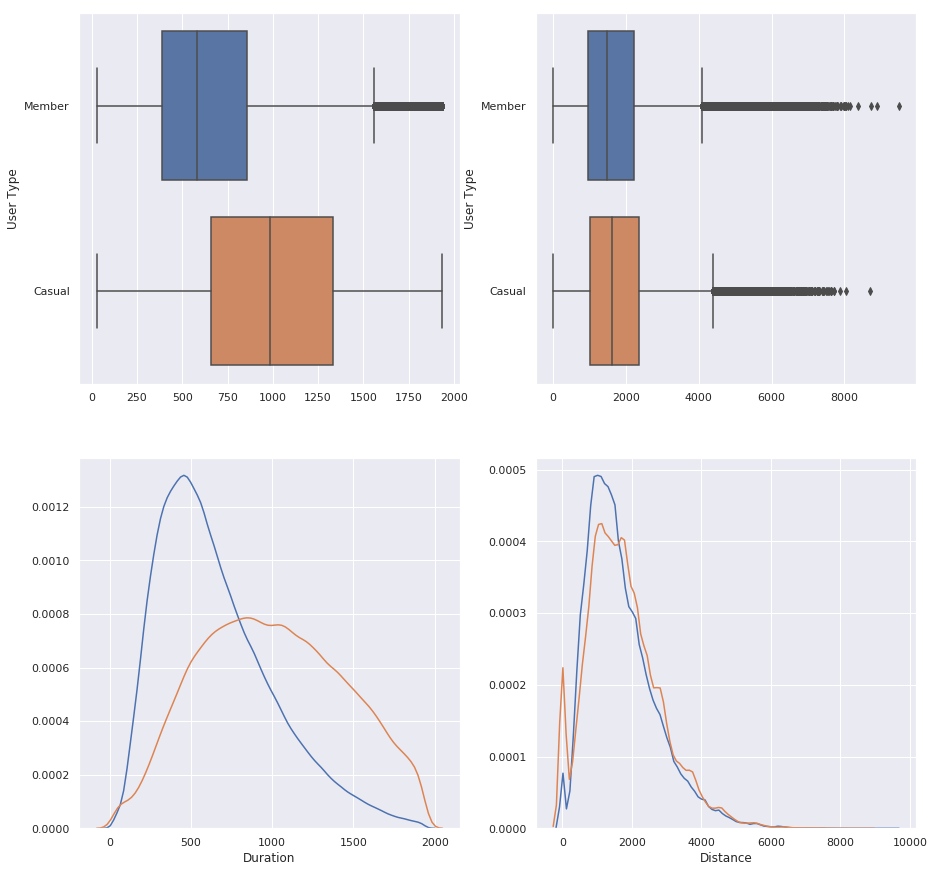

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))

for i, col in enumerate(['Duration', 'Distance']):
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')

plt.savefig('./visualization/distributions.png')

In [9]:
ridership = df.groupby(['Date', 'Quarter', 'Month', 'Day of Week', 'User Type'])['Id'].nunique().reset_index()

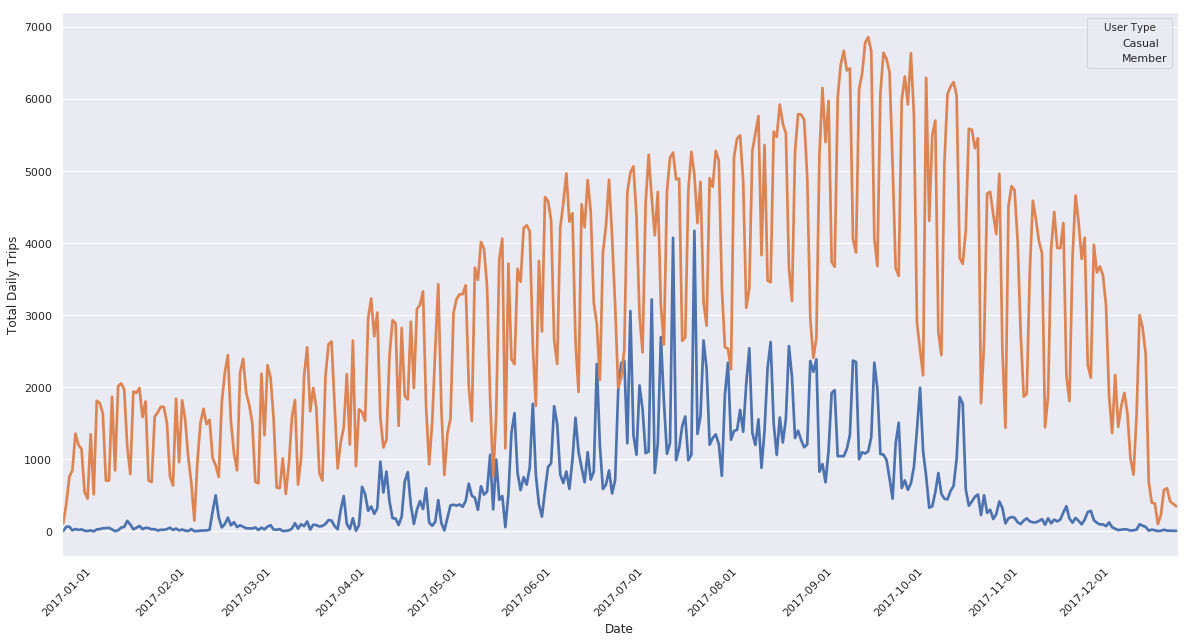

In [190]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.pointplot(x='Date', y='Id', hue='User Type', data=ridership, ax=ax, markers='')
ax.set_ylabel('Total Daily Trips')
ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in ax.get_xticklabels()], rotation=45)

plt.savefig('./visualization/ridership.png')

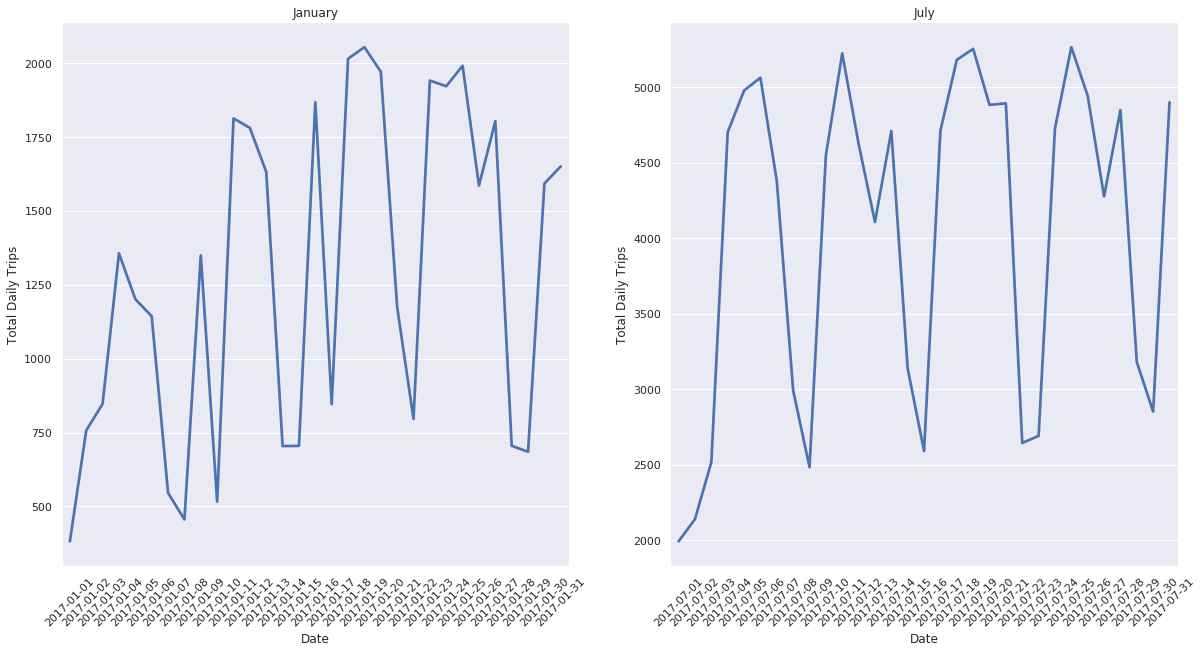

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax, m in zip(axes, ['January', 'July']):
    sns.pointplot(x='Date', y='Id', data=ridership[(ridership['Month']==m)&(ridership['User Type']=='Member')].groupby('Date')['Id'].sum().reset_index(), ax=ax, markers='')
    
    ax.set_title(m)
    ax.set_ylabel('Total Daily Trips')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.savefig('./visualization/ridership_selection.png')

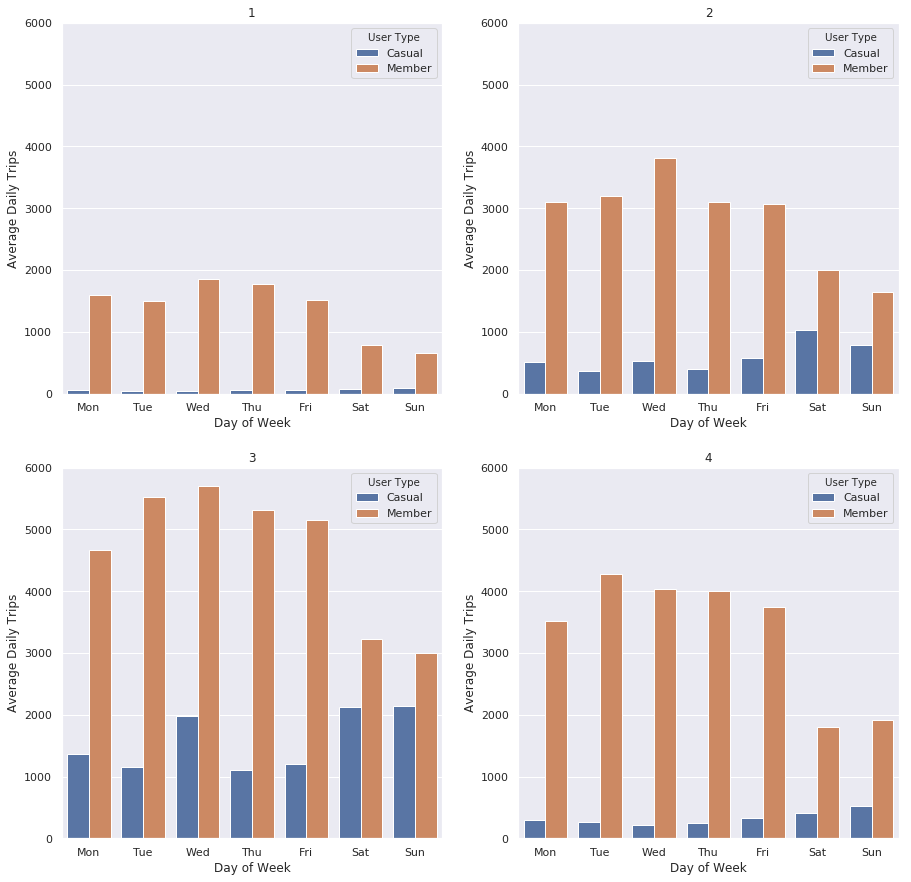

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = np.array(axes).flatten()

for q, ax in zip(sorted(ridership['Quarter'].unique()), axes):
    ax.set_title(q)
    ax.set_ylim(0, 6000)
    sns.barplot(x='Day of Week', 
                y='Id', 
                hue='User Type', 
                data=ridership[ridership['Quarter']==q].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index(), ax=ax)
    ax.set_ylabel('Average Daily Trips')

plt.savefig('./visualization/quarterly.png')

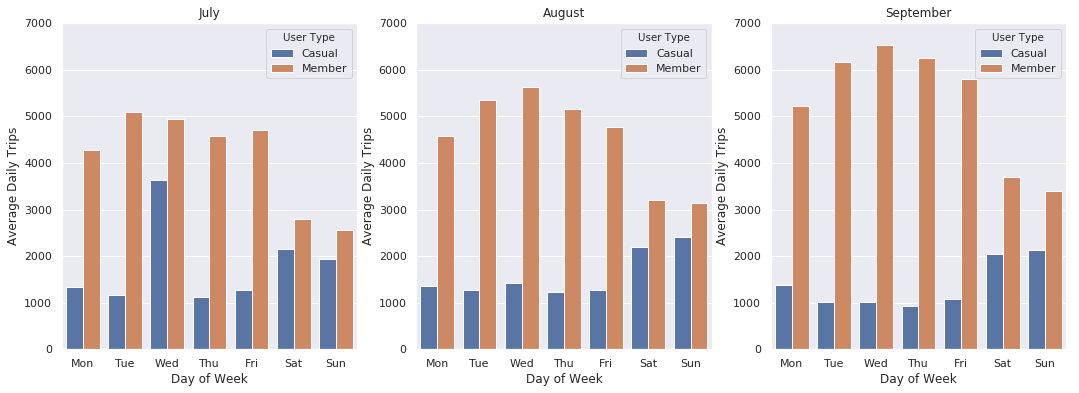

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = np.array(axes).flatten()

for m, ax in zip(ridership[ridership['Quarter']==3]['Month'].unique(), axes):
    ax.set_title(m)
    ax.set_ylim(0, 7000)
    sns.barplot(x='Day of Week', 
                y='Id', 
                hue='User Type', 
                data=ridership[ridership['Month']==m].groupby(['Day of Week', 'User Type'])['Id'].mean().reset_index(), ax=ax)
    ax.set_ylabel('Average Daily Trips')
plt.savefig('./visualization/third_quarter.png')

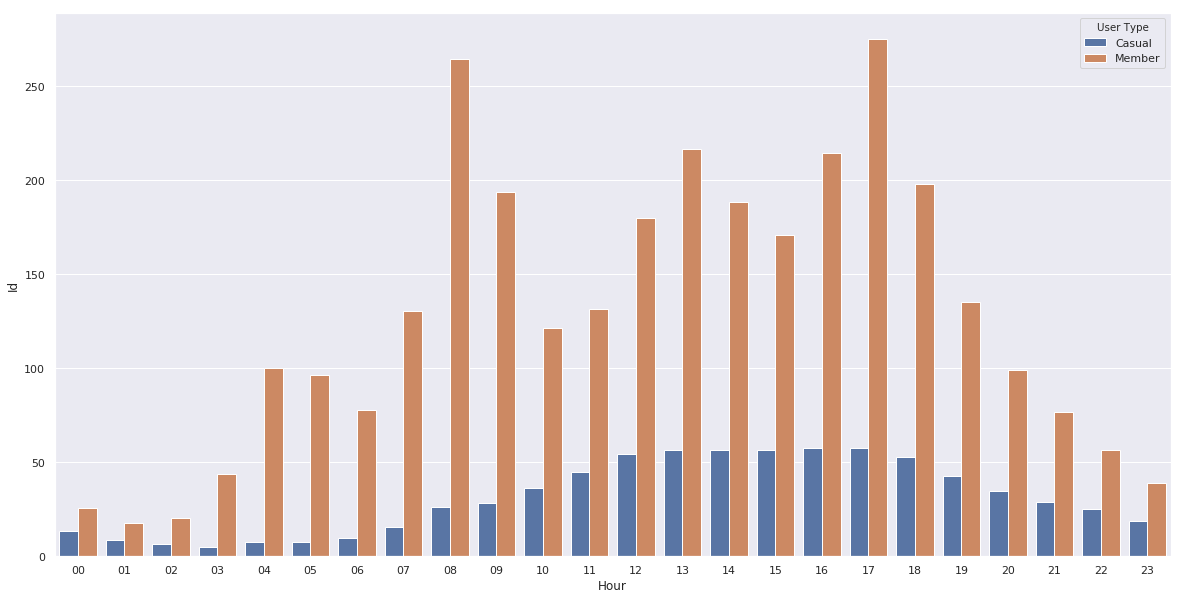

In [14]:
data = df.groupby(['Date', 'Hour', 'User Type'])['Id'].nunique().groupby(['Hour', 'User Type']).mean().reset_index()

fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x='Hour', y='Id', hue='User Type', data=data, ax=ax)
plt.savefig('./visualization/hourly.png')

In [15]:
weather = pd.read_csv('./data/weather_2017.csv')
weather['date'] = weather['datetime'].apply(lambda x: x.split(' ')[0])
weather.columns = [' '.join(x.split('_')).title() for x in weather.columns]

data = df.groupby(['Date', 'User Type'])['Id'].nunique().to_frame().pivot_table(index='Date', columns='User Type').reset_index()
data.columns = ['Date', 'Casual Trips', 'Member Trips']

data = data.merge(weather[['Date', 'Mean Temp', 'Total Precip']], on='Date', how='inner')

/home/dottyz/virtualenv/open-data/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/dottyz/virtualenv/open-data/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


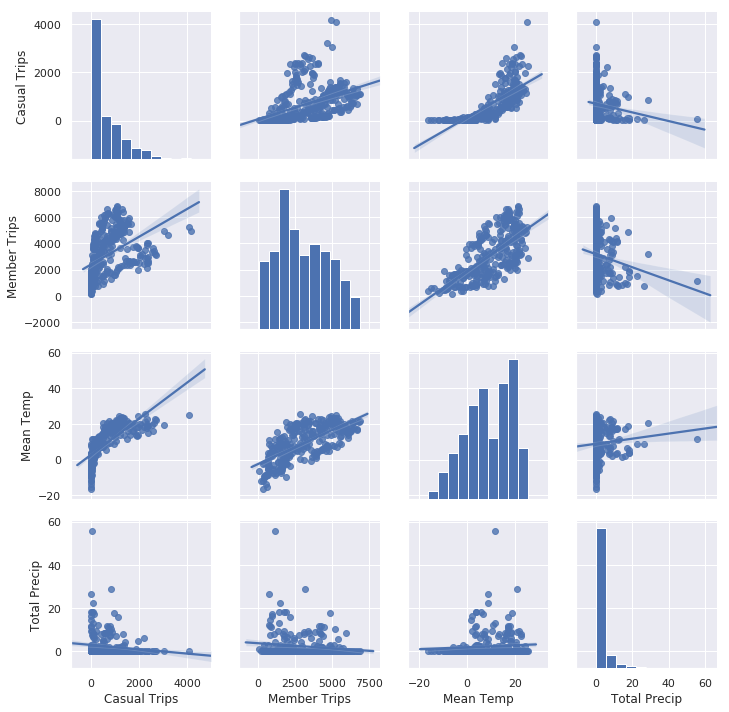

In [54]:
g = sns.pairplot(data, kind='reg')
g.fig.set_size_inches(10, 10)

g.savefig('./visualization/pair.png')

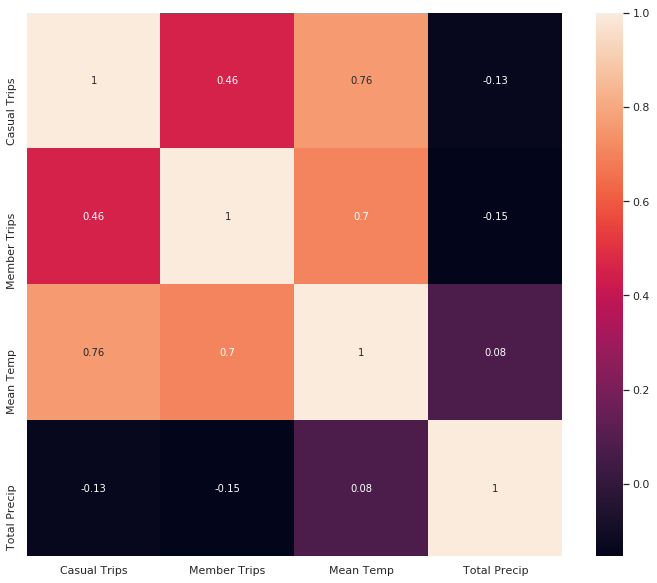

In [65]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True)

plt.savefig('./visualization/heatmap.png')

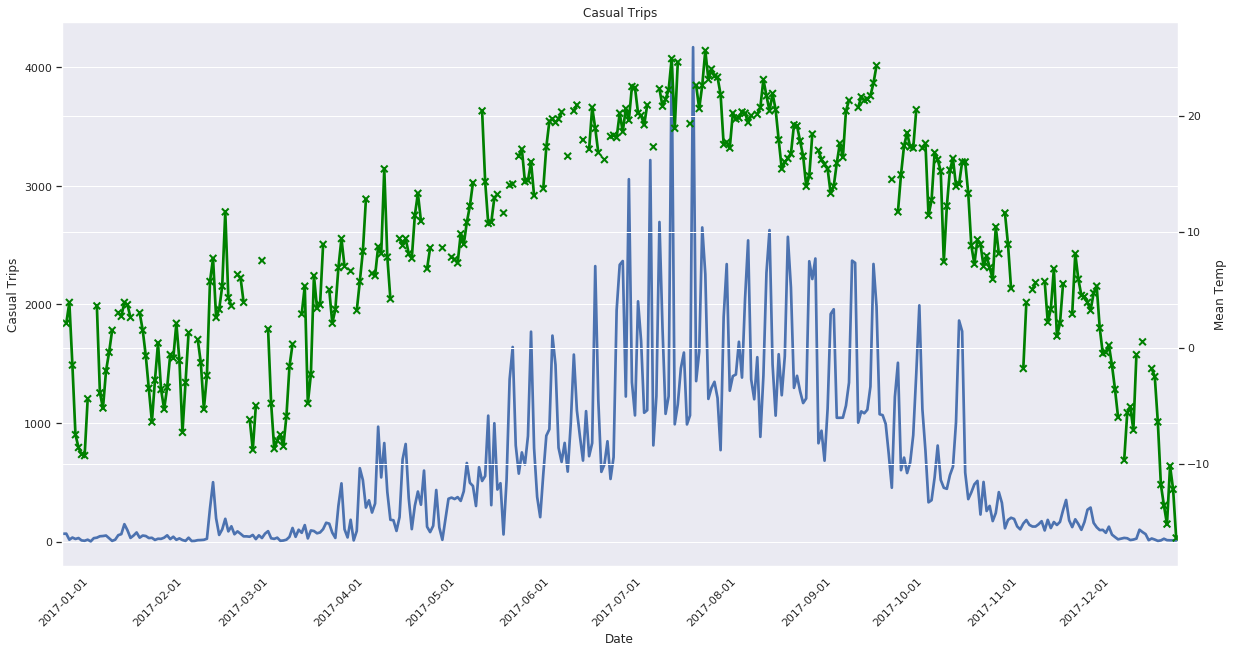

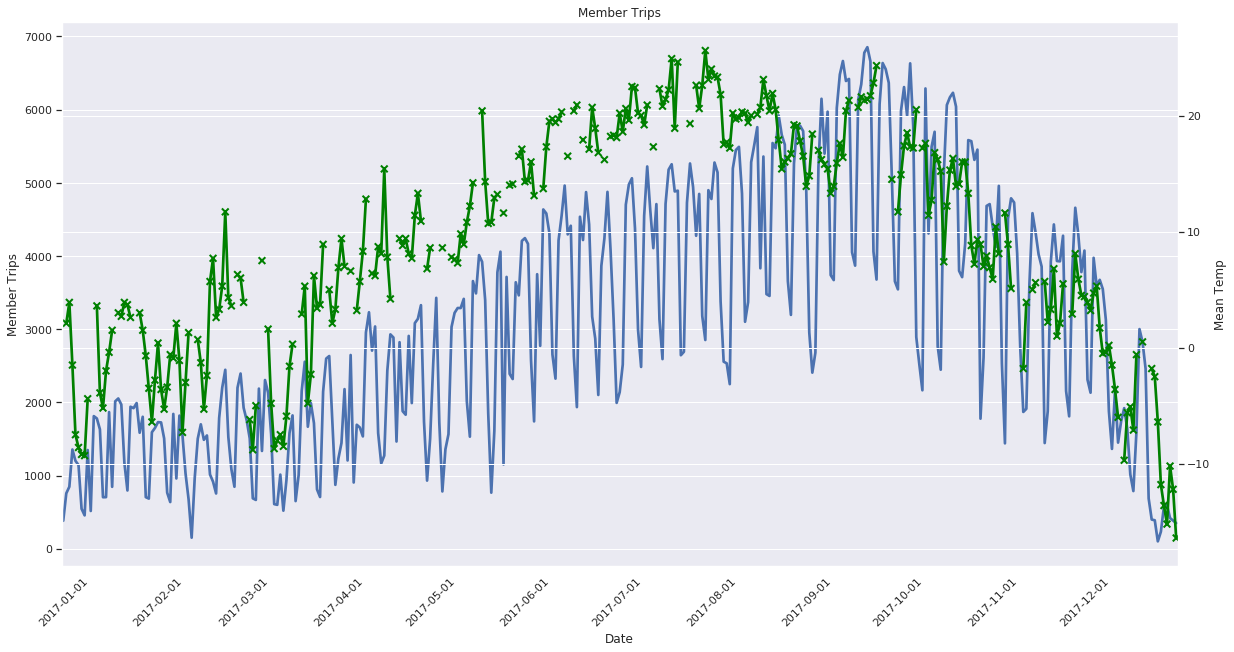

In [69]:
for user_type in ['Casual Trips', 'Member Trips']:
    fig, ax = plt.subplots(figsize=(20, 10))
    ax2 = ax.twinx()

    sns.pointplot(x='Date', y=user_type, data=data, ax=ax, markers='')
    sns.pointplot(x='Date', y='Mean Temp', data=data, ax=ax2, color='green', markers='x')

    ax.set_title(user_type)
    ax.set_xticklabels([x.set_text('') if not x.get_text().endswith('-01') else x for x in ax.get_xticklabels()], rotation=45)

    plt.savefig('./visualization/temperature_{0}.png'.format(user_type))

In [161]:
data = data.sort_values('Mean Temp').dropna().reset_index(drop=True)

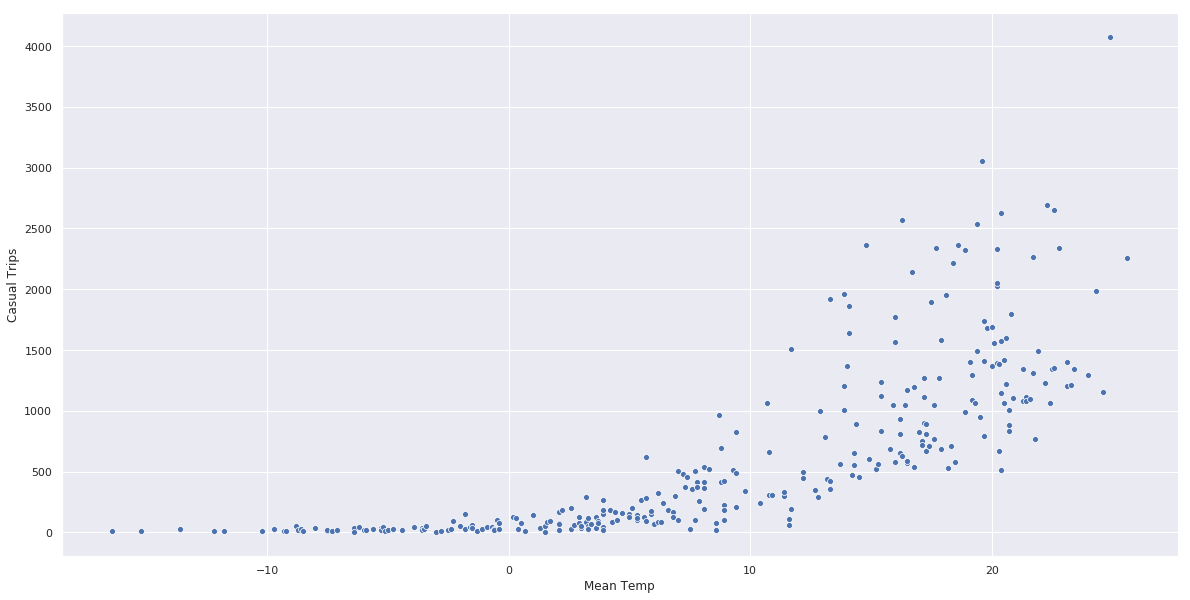

In [162]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.scatterplot(x='Mean Temp', y='Casual Trips', data=data)
plt.savefig('./visualization/fit_0.png')

In [163]:
from kneed import KneeLocator
from scipy.optimize import curve_fit


def linear(x, m, b):
    return m*x + b

def exp_growth_no_shift(x, a, b):
    return a * np.exp(-b * x)

def exp_growth(x, a, b, c):
    return a * np.exp(-b * x) + c

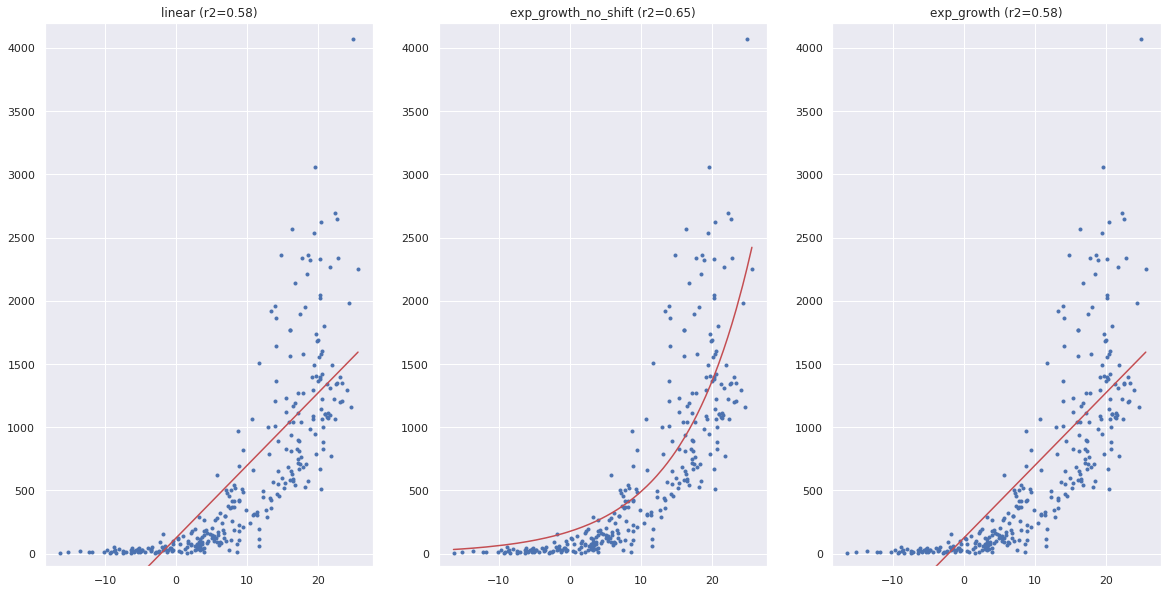

In [164]:
x = data['Mean Temp'].values
y = data['Casual Trips'].values

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for ax, func in zip(axes, [linear, exp_growth_no_shift, exp_growth]):
    popt, pcov = curve_fit(func, x, y, maxfev=2000)
    y_fit = func(x, *popt)
    
    r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

    ax.plot(x, y, '.')
    ax.plot(x, y_fit, 'r-')
    ax.set_ylim(-100, 4200)
    ax.set_title('{0} (r2={1})'.format(func.__name__, np.round(r2, 2)))

plt.savefig('./visualization/fig_1.png')

In [165]:
popt, pcov = curve_fit(exp_growth_no_shift, x, y, maxfev=2000)

kneedle = KneeLocator(x=x, y=exp_growth_no_shift(x, *popt), curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

16.0


In [167]:
def logistic_growth(x, k, x0):
    return 1 / (1 + np.exp(-k*(x - x0)))

In [166]:
data['Cummulative Trips'] = data['Casual Trips'].cumsum()
data['Percentage Trips'] = data['Cummulative Trips'] / data['Casual Trips'].sum()

In [168]:
x = data['Mean Temp'].values
y = data['Percentage Trips'].values

popt, pcov = curve_fit(logistic_growth, x, y, maxfev=2000)
y_fit = logistic_growth(x, *popt)

In [172]:
kneedle = KneeLocator(x=x, y=y_fit, curve='convex', direction='increasing')
knee_start = kneedle.knee

print(knee_start)

15.4


In [181]:
for idx, val in enumerate(x):
    if val > knee_start:
        break
        
kneedle = KneeLocator(x=x[idx:], y=y_fit[idx:], curve='concave', direction='increasing')
knee_end = kneedle.knee

print(knee_end)

20.2


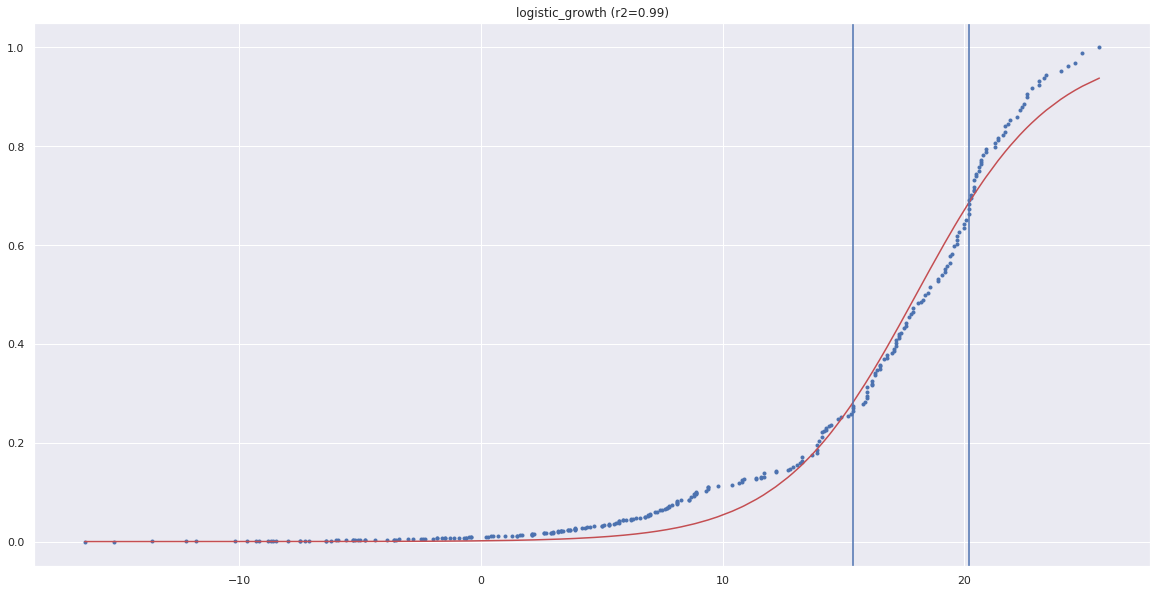

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

r2 = 1 - (np.sum((y - y_fit) ** 2) / np.sum((y - np.mean(y)) ** 2))

ax.plot(x, y, '.')
ax.plot(x, y_fit, 'r-')
ax.axvline(knee_start)
ax.axvline(knee_end)
ax.set_title('{0} (r2={1})'.format('logistic_growth', np.round(r2, 2)))

plt.savefig('./visualization/fit_3.png')

In [134]:
knee_end, knee_start

(19.4, 13.3)